In [6]:
import tensorquant as tq
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date

# Settings

In [2]:
tq.Settings.evaluation_date = date(2024, 7, 31)

calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date


# Market

In [3]:
ref_date = date(2024, 7, 31)
daycounter = tq.DayCounter(tq.DayCounterConvention.ActualActual)

mkt = pd.read_excel("data/market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates = estr_df['quote'].values/100
times = [daycounter.day_count(ref_date, d) for d in estr_df['end']]
#tq
rate_curve = tq.RateCurve(reference_date=ref_date,
                         pillars=estr_df['end'],
                         rates=rates,
                         interp='LINEAR',
                         daycounter_convention=tq.DayCounterConvention.ActualActual)
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR)

# Brownian Motion

In an Arithmetic Brownian Motion (ABM), the stochastic process $X(t)$ evolves according to the following stochastic differential equation (SDE):

$$
dX(t) = \mu dt + \sigma dW(t),
$$

where:
- $\mu$ is the drift term (the constant rate of change),
- $\sigma$ is the volatility (standard deviation of the increments),
- $W(t)$ is a standard Wiener process (Brownian motion).

The solution to this SDE can be expressed as:

$$
X(t) = X(0) + \mu t + \sigma W(t),
$$

where $X(0)$ is the initial value of the process at time $t=0$. The increments of $X(t)$ are normally distributed:

$$
X(t) \sim \mathcal{N}(X(0) + \mu t, \sigma^2 t).
$$


In [23]:
bm = tq.ArithmeticBrownianMotion(mu=0.03, sigma=0.2, x0=100)

In [24]:
n_path = 200000
timesteps = 100
z = tf.random.normal((n_path, timesteps), seed=12, dtype=tf.dtypes.float64)
t = tf.Variable(10, dtype=tf.float64)
s_t = bm.evolve(t, z)

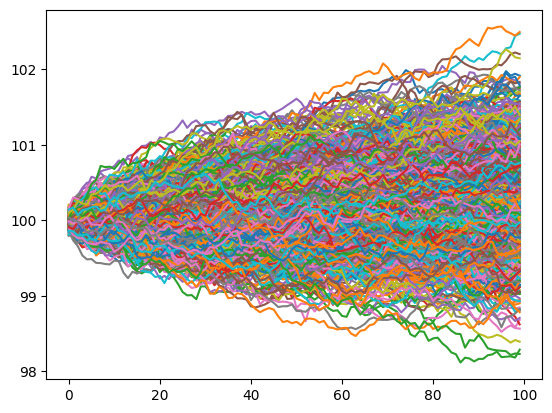

In [25]:
i = 1000
plt.plot(tf.transpose(s_t[:i,:]))
plt.show()

# Geometric Brownian Motion

In a Geometric Brownian Motion (GBM), the stochastic process $S(t)$ typically represents asset prices and evolves according to the following SDE:

$$
dS(t) = \mu S(t) dt + \sigma S(t) dW(t),
$$

where:
- $\mu$ is the drift term (expected return),
- $\sigma$ is the volatility (standard deviation of the returns),
- $W(t)$ is a standard Wiener process (Brownian motion).

The solution to this SDE is given by:

$$
S(t) = S(0) e^{\left(\mu - \frac{1}{2} \sigma^2\right)t + \sigma W(t)},
$$

where $S(0)$ is the initial price of the asset at time $t=0$. 

The logarithm of $S(t)$ follows a normal distribution:

$$
\ln S(t) \sim \mathcal{N}\left(\ln S(0) + \left(\mu - \frac{1}{2} \sigma^2\right)t, \sigma^2 t\right).
$$

In [8]:
gbm = tq.GeometricBrownianMotion(mu=0.03, sigma=0.2, x0=100)

In [22]:
n_path = 200000
timesteps = 100
z = tf.random.normal((n_path, timesteps), seed=12, dtype=tf.dtypes.float64)
t = tf.Variable(10, dtype=tf.float64)
s_t = gbm.evolve(t, z)

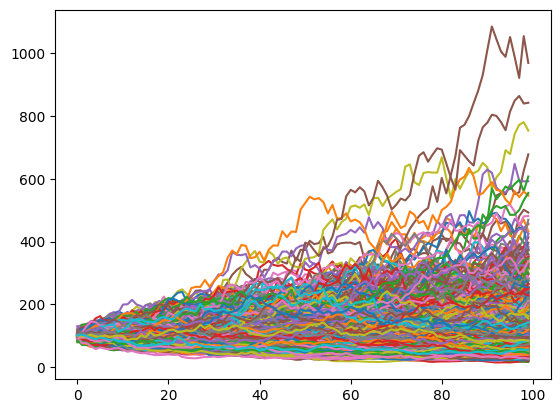

In [21]:
i = 1000
plt.plot(tf.transpose(s_t[:i,:]))
plt.show()

# One Factor Gaussian Short Rate (HW)

Recalling the definition of the money market account where $r(t)$ is the short rate representing the continuously compounded rate at which the risk-free investment increases:

$$
dB(t) = r(t) B(t)dt,
$$

with $r(t)$ that evolves under the risk-neutral measure according to

$$
dr(t) = [\theta(t) - \kappa r(t)] dt + \sigma dW(t),
$$

now consider $\kappa$ and $\sigma$ to be positive constants, with $\theta$ chosen to fit the currently observed yield curve in the market:

$$
\theta(t) = \frac{\partial}{\partial t}f^M(0,t) + \kappa f^M(0,t) + \frac{\sigma^2}{2\kappa}(1 - e^{-2\kappa t}),
$$

where $\frac{\partial}{\partial t}f^M(0,t)$ denotes the partial derivative of $f^M$ with respect to its second argument, and $f^M(0,t)$ being the market instantaneous forward rate at time 0 for maturity $t$:

$$
f^M(0,T) = - \frac{\partial}{\partial t} \ln P(0,t),
$$

**One Factor Gaussian Short Rate (HW) - Conditional Mean and Variance** with $P^M(0,t)$ being the market discount factor for maturity $t$. The equation can be integrated to obtain:

$$
r(t) = r(s) e^{-\kappa(t-s)} + \alpha(t) - \alpha(s) e^{-\kappa(t-s)} + \sigma \int_{s}^{t} e^{-\kappa(t-u)} dW(u),
$$

where

$$
\alpha(t) = f^M(0,t) + \frac{\sigma^2}{2\kappa^2}(1 - e^{-\kappa t})^2,
$$

$r(t)$ conditional on $r(s)$ with $t > s$ is Normally distributed with mean and variance given respectively by:

$$
\mathbb{E}[r(t)\vert r(s)] = r(s) e^{-\kappa(t-s)} + \alpha(t) - \alpha(s) e^{-\kappa(t-s)},
$$

$$
\text{Var}[r(t)\vert r(s)] = \frac{\sigma^2}{2\kappa} [1 - e^{-2\kappa(t-s)}].
$$

It's possible to obtain the price for zero-coupon bonds, allowing us to compute a new term structure as a function of a given short rate. It's shown that:

$$
P(t,T) = A(t,T) e^{-B(t,T) r(t)},
$$

where

$$
B(t,T) = \frac{1 - e^{-\kappa(T-t)}}{\kappa},
$$

$$
A(t,T) = \frac{P(0,T)}{P(0,t)} \exp \left(B(t,T) f^M(0,t) - \frac{\sigma^2}{4\kappa}(1 - e^{-2\kappa t}) B(t,T)^2 \right).
$$


In [4]:
a = 0.03
sigma = 0.02

hw_tq = tq.HullWhiteProcess(rate_curve, a, sigma)

schedule_gen = tq.ScheduleGenerator(calendar, tq.BusinessDayConvention.Unadjusted)
end_date = calendar.advance(evaluation_date, 30, tq.TimeUnit.Years, tq.BusinessDayConvention.ModifiedFollowing)
dates = schedule_gen.generate(evaluation_date, end_date, 6, tq.TimeUnit.Months)
date_grid = tq.DateGrid(dates, tq.DayCounterConvention.ActualActual)

kernel = tq.HullWhiteShortRateGenerator(hw_tq, date_grid)

kernel.simulate(n_paths=1000)
short_rate_df = pd.DataFrame(kernel.state_variable).T

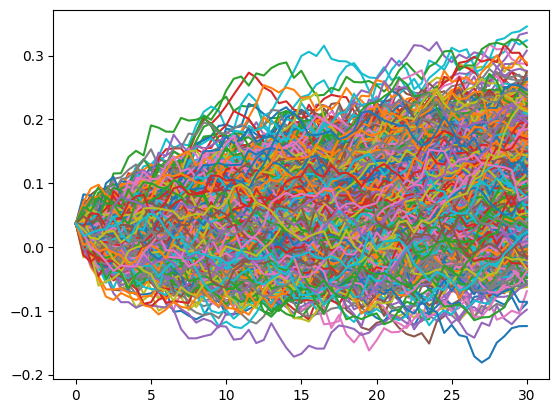

In [5]:
plt.plot(date_grid.times, short_rate_df)
plt.show()